In [ ]:
pip install spacy

In [5]:
!python -m spacy download en_core_web_sm

     -------------------------------------- 12.8/12.8 MB 328.8 kB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
df = pd.read_csv('./DataSet/Reviews.csv')

In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**DATA CLEANING**

In [9]:
len(df)

568454

Checking Any Null Values

In [10]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [11]:
df.dropna(inplace=True)
blanks=[]

In [12]:
for sumy in df['Summary']:
    if(sumy.isspace()):
        blanks.append()

In [13]:
for pn in df['ProfileName']:
    if(pn.isspace()):
        blanks.append()

Droping The Null Values

In [14]:
df.drop(blanks,inplace=True)

No Null Values

In [15]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [16]:
len(df)

568411

In [17]:
df = df[['Score', 'Text', 'Summary']]
df['Sentiment'] = df['Score'].apply(lambda score: 'very negative' if score <= 1
                                    else 'negative' if score <= 2
                                    else 'neutral' if score <= 3
                                    else 'positive' if score <= 4
                                    else 'very positive')

In [18]:
df.head()

,Score,Text,Summary,Sentiment
0,5,I have bought several of the Vitality canned d...,Good Quality Dog Food,very positive
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,very negative
2,4,This is a confection that has been around a fe...,"""Delight"" says it all",positive
3,2,If you are looking for the secret ingredient i...,Cough Medicine,negative
4,5,Great taffy at a great price. There was a wid...,Great taffy,very positive


In [19]:
df1 = df.copy()[:100000]

In [20]:
#Text Cleaning

import re
def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuations
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    return text

df1['Text'] = df1['Text'].apply(clean_text)


In [21]:
df1["Sentiment"].value_counts()

very positive    62415
positive         14643
very negative     9317
neutral           8060
negative          5565
Name: Sentiment, dtype: int64

<BarContainer object of 5 artists>

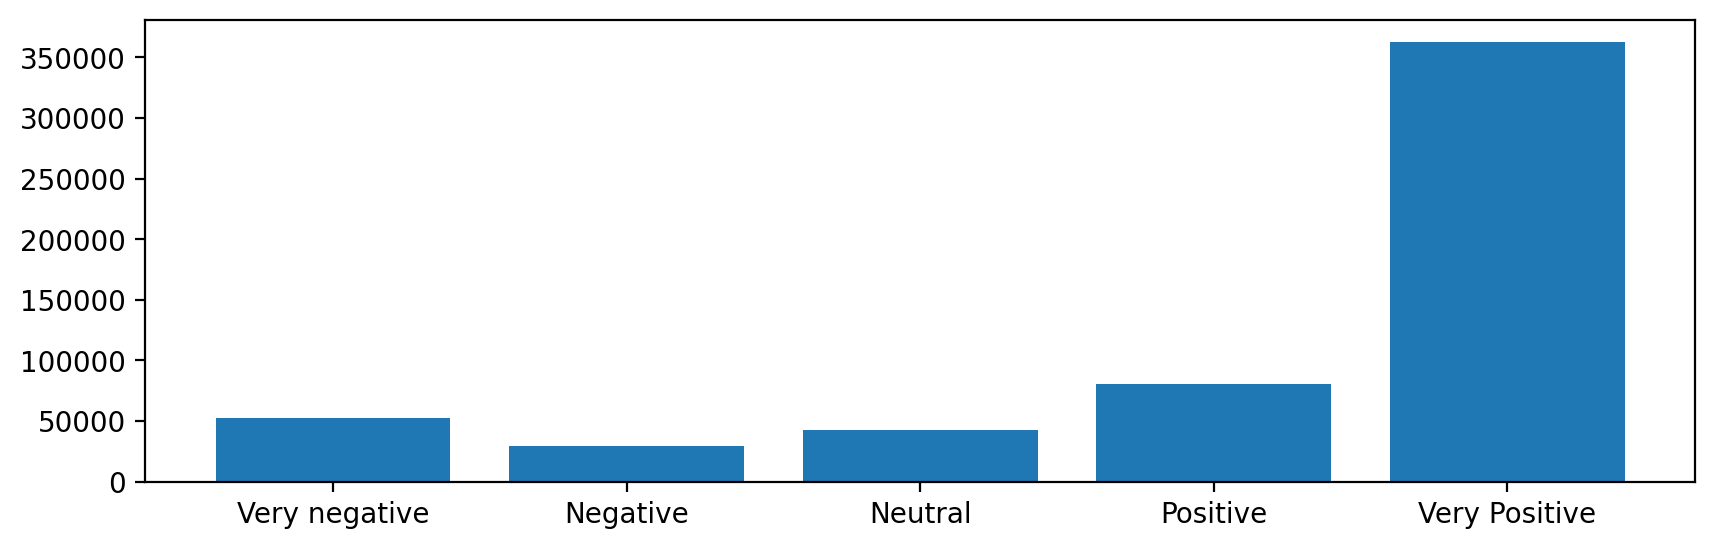

In [22]:
def count(response,y):
    
    c=0;
    for r in rating:
        if r==response:
            c += 1
           
    return c
graph_x = np.array(['Very negative', 'Negative','Neutral', 'Positive','Very Positive'])
rating = np.array(df['Sentiment'])
c1 = count('very negative',rating)
c2 = count('negative',rating)
c3 = count('neutral',rating)
c4 = count('positive',rating)
c5 = count('very positive',rating)

graph_y = np.array([c1,c2,c3,c4,c5])
fig = plt.figure(figsize=(10,3),dpi=200);
plt.bar(graph_x,graph_y)

**Text Pre-processing**

In [23]:
df1['Text'] = df1['Text'].apply(
    lambda text: 
        " ".join(
            token.lemma_ for token in nlp(text)
                if token.lemma_.lower() not in nlp.Defaults.stop_words and token.is_alpha
        )
)      

In [24]:
custom_stop_words = ["the", "and", "or", "not", "to"]

def custom_filter(token):
    return not (token.is_stop or token.is_punct or len(token) < 3)

def preprocess_text(text):
    doc = nlp(text)
    return " ".join(
        token.lemma_ for token in doc
        if token.lemma_.lower() not in custom_stop_words and custom_filter(token)
    )

df1["Processed Text"] = df1["Text"].apply(lambda x: preprocess_text(x))

In [25]:
txt_Pro = pd.DataFrame(df1)
txt_Pro.to_csv("./DataSet/ProcessedData.csv")

In [26]:
df1 = pd.read_csv("ProcessedData.csv")

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
X=df1['Processed Text']
y=df1['Sentiment']
df1.head()
len(df1)

100000

In [29]:
X.head()

0    buy vitality dog food product find good qualit...
1    product arrive label jumbo salt peanutsthe pea...
2    confection century light pillowy citrus gelati...
3    look secret ingredient robitussin believe find...
4    great taffy great price wide assortment yummy ...
Name: Processed Text, dtype: object

Continued In 80% ipynb file...